## SIM Training by Stein's Method

In [4]:
import numpy as np
from matplotlib import pylab as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer, roc_auc_score

from pysim import SIMClassifier

## pySIM - A python package for Sparse SIM 

**To install**:
    
```sheel
    pip install git+https://github.com/Zebinyang/pysim.git
```

Note pysim will call the R package fps (https://github.com/vqv/fps) using rpy2 interface. 

```python
from pysim import SIMClassifier
clf = SIMClassifier(method="first_order", spline="a_spline", reg_lambda=0.1, reg_gamma=0.1, knot_num=20, degree=2, random_state=0)
## clf.fit(x, y)
```

**Usage**

**Hyperparameters**

- task: the task type, including "Regression" and "Classification". default="Regression"

- method: the base method for estimating the projection coefficients in sparse SIM. default="first"

        "first_order": First-order Stein's Identity via sparse PCA solver

        "second_order": Second-order Stein's Identity via sparse PCA solver

        "first_order_thres": First-order Stein's Identity via hard thresholding (A simplified verison)        
    
- spline: The type of spline method. default="augbs"

        "p_spline": p-spline (from pygam package)
    
        "p_spline_mono": p-spline with monotonic constraint (from pygam package)
    
        "a_spline": adaptive spline where knots are automatically selected (see Goepp, V., Bouaziz, O. and Nuel, G., 2018. Spline regression with automatic knot selection. arXiv preprint arXiv:1808.01770.)

- reg_lambda: The regularization strength of sparsity of beta. default=0.1, from 0 to 1 

- reg_gamma: The regularization strength of the spline algorithm. default=0.1, from 0 to $+\infty$

- degree: The order of the spline basis. default=2

- knot_num: The number of knots spanned uniformly over the domain. default=20

- random_state: the random seed. default=0

# Case 1: Sine Ridge Function

- covariates: $x\sim N(0, 0.3^2)$
- ridge function: $ f(u) = \sin{(u\pi)} $
- projection: $ u = \beta^{T} x $, where $\beta$ has 5 non-zero entries
- noise: $N(0, 1)$
- sample size: 10000
- feature size: 100

In [5]:
s_star = 5
n_features = 100
n_samples = 10000

np.random.seed(0)
beta = np.zeros(n_features)
supp_ids = np.random.choice(n_features, s_star)
beta[supp_ids]=np.random.choice((-1, 1), s_star) / np.sqrt(s_star)

x = np.random.normal(0, 0.3, size=(n_samples, n_features))
y = np.sin(np.pi*(np.dot(x, beta))) + 0.1 * np.random.randn(n_samples)
ymu = np.mean(y)
y[y > ymu] = 1
y[y <= ymu] = 0

The best hyperparameter combination can be selected via cross-validation

In [7]:
%%time 

param_grid = {"method": ["first_order", "second_order"],
              "reg_lambda": [0.05, 0.1], 
              "reg_gamma": np.logspace(-2, 2, 5)}
grid = GridSearchCV(SIMClassifier(degree=2, knot_num=20, spline="a_spline", random_state=0), 
                    cv=KFold(3, shuffle=True, random_state=0), 
                    scoring={"auc": make_scorer(roc_auc_score)},
                    param_grid=param_grid, n_jobs=-1, verbose=2, refit="auc", error_score=np.nan)
grid.fit(x, y)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 out of  60 | elapsed: 96.3min remaining: 125.9min
[Parallel(n_jobs=-1)]: Done  57 out of  60 | elapsed: 96.3min remaining:  5.1min


KeyboardInterrupt: 

In [4]:
grid.best_params_

{'method': 'first', 'reg_gamma': 0.1, 'reg_lambda': 0.05}

**NB**: The first-order Setin's method is selected, as $\mathbb{E}[f^{\prime\prime}(u)]=0$. Therefore, the second order method cannot provide any information about the projection coefficients. 

In this case, the first-order Setin's method is selected. 

In [5]:
clf = grid.best_estimator_
clf

SIM(degree=2, knot_num=20, method='first', random_state=0, reg_gamma=0.1,
    reg_lambda=0.05, spline='augbs', task='Classification')

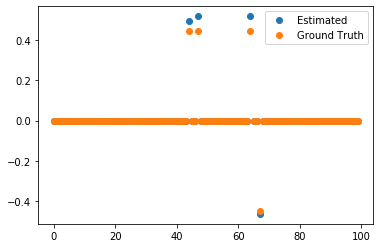

In [6]:
plt.plot(clf.beta_, "o")
plt.plot(beta, "o")
plt.legend(["Estimated", "Ground Truth"])
plt.show()

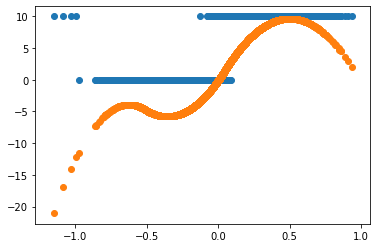

In [7]:
plt.scatter(np.dot(x, beta), 10 * y)
plt.scatter(np.sort(np.dot(x, beta)), grid.best_estimator_.link_fit_.decision_function(np.sort(np.dot(x, beta))))
plt.show()

## Case 2: Quadratic Ridge Function

- covariates: $x\sim N(0, 0.3^2)$
- ridge function: $ f(u) = u^{2} $
- projection: $ u = \beta^{T} x $, where $\beta$ has 5 non-zero entries
- noise: $N(0, 1)$
- sample size: 10000
- feature size: 100

In [8]:
s_star = 5
n_features = 100
n_samples = 10000

np.random.seed(0)
beta = np.zeros(n_features)
supp_ids = np.random.choice(n_features, s_star)
beta[supp_ids]=np.random.choice((-1, 1), s_star) / np.sqrt(s_star)

x = np.random.normal(0, 0.3, size=(n_samples, n_features))
y = np.dot(x, beta) ** 2 + 0.1 * np.random.randn(n_samples)
ymu = np.mean(y)
y[y > ymu] = 1
y[y <= ymu] = 0

In [10]:
%%time 

param_grid = {"method": ["first_order", "second_order"],
              "reg_lambda": [0.05, 0.1], 
              "reg_gamma": np.logspace(-2, 2, 5)}
grid = GridSearchCV(SIMClassifier(degree=2, knot_num=20, spline="a_spline", random_state=0), 
                    cv=KFold(3, shuffle=True, random_state=0), 
                    scoring={"auc": make_scorer(roc_auc_score)},
                    param_grid=param_grid, n_jobs=-1, verbose=2, refit="auc", error_score=np.nan)
grid.fit(x, y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of 100 | elapsed: 17.0min remaining: 53.8min
[Parallel(n_jobs=-1)]: Done  75 out of 100 | elapsed: 27.8min remaining:  9.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 28.3min finished


CPU times: user 15min 8s, sys: 26min 31s, total: 41min 40s
Wall time: 30min 2s


In [11]:
grid.best_params_

{'method': 'second', 'reg_gamma': 10.0, 'reg_lambda': 0.05}

**NB**: The second-order Setin's method is selected, as $\mathbb{E}[f^{\prime}(u)]=0$. Therefore, the first order method cannot provide any information about the projection coefficients. 

In [12]:
clf = grid.best_estimator_
clf

SIM(degree=2, knot_num=20, method='second', random_state=0, reg_gamma=10.0,
    reg_lambda=0.05, spline='augbs', task='Classification')

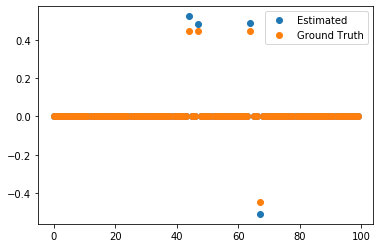

In [13]:
plt.plot(clf.beta_, "o")
plt.plot(beta, "o")
plt.legend(["Estimated", "Ground Truth"])
plt.show()

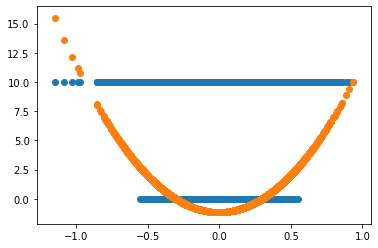

In [14]:
plt.scatter(np.dot(x, beta), 10 * y)
plt.scatter(np.sort(np.dot(x, beta)), grid.best_estimator_.link_fit_.decision_function(np.sort(np.dot(x, beta))))
plt.show()